In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')
from fbprophet import Prophet as proph
import numpy as np

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [7]:
def plot_model(df, zipcode):
    """
    
    """
    model, forecast, zipcode = model_price(df, zipcode, '2005-04-01', '2018-04-01')
    model.plot(forecast, uncertainty=True)
    plt.title(zipcode)
    plt.show()

In [3]:
all_df = pd.read_csv('raw_data/zillow_data.csv')

In [29]:
all_df.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600


In [53]:
all_df.shape[0] - no_nan_df.shape[0]

801

In [51]:
no_nan_df = pd.concat([all_df['RegionName'], all_df.loc[:, '2005-04': '2018-04']], axis=1).dropna()
no_nan_df['RegionName']

(13922, 158)

In [43]:
all_df['RegionName']

0        60657
1        75070
2        77494
3        60614
4        79936
         ...  
14718     1338
14719     3293
14720    40404
14721    81225
14722    89155
Name: RegionName, Length: 14723, dtype: int64

In [46]:
all_df.loc[:, '2005-04': '2018-04']

,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,201000.0,201000.0,201000.0,200900.0,200900.0,200900.0,201200.0,201600.0,202200.0,202700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,241800.0,241700.0,240700.0,239300.0,238000.0,236800.0,235700.0,234700.0,233400.0,231700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,1100500.0,1107400.0,1113500.0,1118800.0,1123700.0,1129200.0,1135400.0,1141900.0,1148000.0,1152800.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,95800.0,96300.0,96700.0,97200.0,97700.0,98400.0,99000.0,99600.0,100200.0,101000.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,190000.0,193400.0,197200.0,200600.0,203100.0,204400.0,205000.0,205300.0,205400.0,205500.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,203000.0,208000.0,212700.0,216800.0,220000.0,222300.0,223600.0,224000.0,223400.0,222000.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,102600.0,104100.0,105600.0,106900.0,108300.0,109600.0,110800.0,111700.0,112600.0,113200.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,553500.0,564600.0,575100.0,584500.0,591800.0,596800.0,600000.0,601800.0,602500.0,602500.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [27]:
all_df.loc[all_df['RegionName']==29405, '2004-09':].T.head(50)

,4309
2004-09,NaN
2004-10,NaN
2004-11,NaN
2004-12,NaN
2005-01,NaN
2005-02,NaN
2005-03,NaN
2005-04,NaN
2005-05,NaN
2005-06,NaN


In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
def model_price(df, zipcode, start, end, periods=60, freq='MS', interval_width=0.80):
    """

    """
    df = melt_data(df.loc[df['RegionName'] == zipcode])
    print(df)
    df = df.reset_index()
    df.columns = ['ds', 'y']
    print(df)
    data = df.loc[(df['ds'] > start) & (df['ds'] < end)]
    print(df)
    Model = proph(interval_width=interval_width)
    Model.fit(data)
    future_dates = Model.make_future_dataframe(periods=periods, freq=freq)
    forecast = Model.predict(future_dates)
    print(forecast)
    return Model, forecast, zipcode

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


               value
time                
2014-01-01   56500.0
2014-02-01   57000.0
2014-03-01   56000.0
2014-04-01   54700.0
2014-05-01   54500.0
2014-06-01   55800.0
2014-07-01   57500.0
2014-08-01   58300.0
2014-09-01   58000.0
2014-10-01   58600.0
2014-11-01   59400.0
2014-12-01   59200.0
2015-01-01   58800.0
2015-02-01   58700.0
2015-03-01   58100.0
2015-04-01   58500.0
2015-05-01   59900.0
2015-06-01   61000.0
2015-07-01   61300.0
2015-08-01   61600.0
2015-09-01   61400.0
2015-10-01   60300.0
2015-11-01   59000.0
2015-12-01   59100.0
2016-01-01   59800.0
2016-02-01   60000.0
2016-03-01   59900.0
2016-04-01   60400.0
2016-05-01   61700.0
2016-06-01   63000.0
2016-07-01   63300.0
2016-08-01   63000.0
2016-09-01   62800.0
2016-10-01   63300.0
2016-11-01   64900.0
2016-12-01   66500.0
2017-01-01   67600.0
2017-02-01   69500.0
2017-03-01   72500.0
2017-04-01   75400.0
2017-05-01   78900.0
2017-06-01   82600.0
2017-07-01   86600.0
2017-08-01   90100.0
2017-09-01   92900.0
2017-10-01   

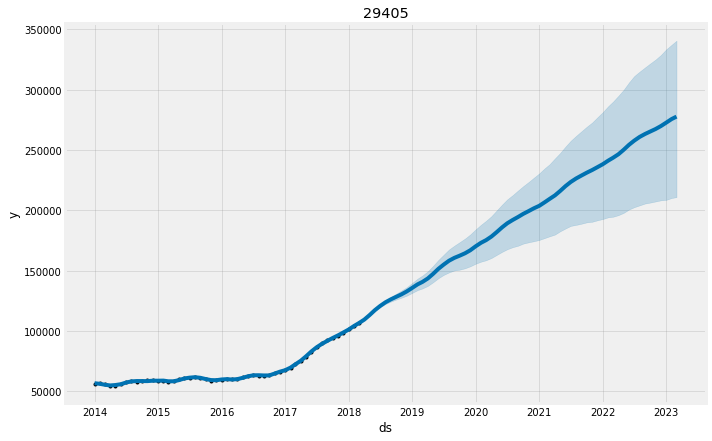

In [10]:
plot_model(all_df, 29405)

In [54]:
stats_df = pd.read_csv('raw_data/stats.csv')

In [62]:
stats_df.head()

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
0,0,60657.0,1.037784e+06,1.070844e+06,0.031856,1.235148e+06,0.190178,1.400055e+06,0.349082
1,0,75070.0,3.236488e+05,3.373065e+05,0.042199,4.194053e+05,0.295865,5.000079e+05,0.544909
2,0,77494.0,3.235428e+05,2.682185e+05,-0.170995,3.284879e+05,0.015284,3.890296e+05,0.202405
3,0,60614.0,1.318618e+06,1.200312e+06,-0.089720,1.523798e+06,0.155602,1.811421e+06,0.373727
4,0,79936.0,1.199760e+05,9.510128e+04,-0.207331,1.301318e+05,0.084649,1.682291e+05,0.402189


In [63]:
stats_df['zipcode'].isin(no_nan_df['RegionName'])

0        True
1        True
2        True
3        True
4        True
         ... 
14718    True
14719    True
14720    True
14721    True
14722    True
Name: zipcode, Length: 14723, dtype: bool

In [77]:
filtered_stats_df = stats_df.loc[stats_df['zipcode'].isin(no_nan_df['RegionName'])]


In [74]:
filtered_stats_df.nlargest(5, 'min_roi')

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
6698,0,29601.0,258638.364509,443344.806296,0.714149,489904.265675,0.894167,534706.042342,1.067389
3157,0,75234.0,238714.471709,398796.551429,0.670601,431148.939508,0.806128,470908.002437,0.972683
3795,0,75224.0,154626.016415,258311.031721,0.670553,286294.568517,0.851529,309818.769862,1.003665
7981,0,27601.0,279042.267747,463695.028026,0.661738,503906.684333,0.805844,540607.696879,0.937368
5323,0,75235.0,180698.814712,298489.913875,0.651864,323096.247915,0.788037,349234.995235,0.932691


In [75]:
filtered_stats_df.nlargest(5, 'expected_roi')

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
4135,0,33563.0,1.528269e+05,2.206014e+05,0.443472,2.917412e+05,0.908965,3.627985e+05,1.373918
6698,0,29601.0,2.586384e+05,4.433448e+05,0.714149,4.899043e+05,0.894167,5.347060e+05,1.067389
3795,0,75224.0,1.546260e+05,2.583110e+05,0.670553,2.862946e+05,0.851529,3.098188e+05,1.003665
2596,0,32211.0,1.410498e+05,2.119523e+05,0.502677,2.591417e+05,0.837235,3.016168e+05,1.138371
191,0,7302.0,1.525514e+06,2.476980e+06,0.623702,2.802050e+06,0.836791,3.142064e+06,1.059676


In [76]:
filtered_stats_df.nlargest(5, 'max_roi')

,Unnamed: 0,zipcode,2018-04-01,minimum,min_roi,expected,expected_roi,maximum,max_roi
2409,0,33404.0,137212.816327,116412.847291,-0.151589,247852.017539,0.806333,383534.044138,1.795177
3342,0,95210.0,247781.881136,129969.311582,-0.475469,377423.557260,0.523209,639428.097098,1.580609
4149,0,48506.0,21338.510102,4699.588027,-0.779760,29668.391848,0.390368,55042.141680,1.579474
4436,0,33936.0,136771.343623,102384.722369,-0.251417,230583.865098,0.685908,352329.559760,1.576048
1154,0,33068.0,218786.911781,190830.148417,-0.127781,374135.226080,0.710044,561376.101551,1.565858


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


               value
time                
1996-04-01   55900.0
1996-05-01   56000.0
1996-06-01   56100.0
1996-07-01   56200.0
1996-08-01   56300.0
...              ...
2017-12-01  142000.0
2018-01-01  142700.0
2018-02-01  144000.0
2018-03-01  145300.0
2018-04-01  146200.0

[265 rows x 1 columns]
            ds         y
0   1996-04-01   55900.0
1   1996-05-01   56000.0
2   1996-06-01   56100.0
3   1996-07-01   56200.0
4   1996-08-01   56300.0
..         ...       ...
260 2017-12-01  142000.0
261 2018-01-01  142700.0
262 2018-02-01  144000.0
263 2018-03-01  145300.0
264 2018-04-01  146200.0

[265 rows x 2 columns]
            ds         y
0   1996-04-01   55900.0
1   1996-05-01   56000.0
2   1996-06-01   56100.0
3   1996-07-01   56200.0
4   1996-08-01   56300.0
..         ...       ...
260 2017-12-01  142000.0
261 2018-01-01  142700.0
262 2018-02-01  144000.0
263 2018-03-01  145300.0
264 2018-04-01  146200.0

[265 rows x 2 columns]
            ds          trend     yhat_lower     yhat_u

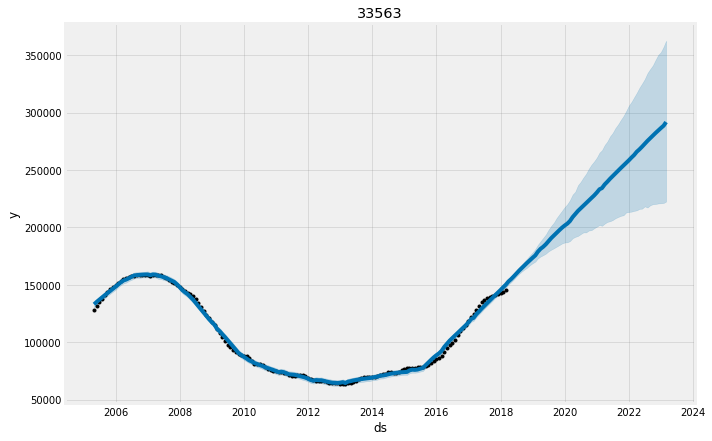

In [78]:
plot_model(all_df, 33563)